## Generating Names using Recurrent Neural Networks 

## Introduction
![What is your Name?](https://media.giphy.com/media/TayI4SCiq0dJ6/giphy.gif)


Struggle to find a name for the variable?  
Let's see how you'll come up with a name for your **son/daughter**. Surely no human has expertize over what is a good child name, so let us train **RNN** instead 😁

**About the Dataset**  
I scraped the Indian-Baby-Names from this [website](https://babynames.extraprepare.com). I used python for web-scraping. The code for scraping is available [here](https://github.com/memr5/Machine-Learning-Portfolio/blob/master/Deep%20Learning/Indian%20Baby%20Names%20Generator/Scraper.py).  
The Dataset contains names of both boys & girls.

<font color="red" size=5>Please!!! Upvote this kernel if you find it useful.</font>

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import string

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
from wordcloud import WordCloud

import tensorflow as tf
print(tf.__version__)

2.5.0


## Load Data
This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [2]:
os.listdir("/kaggle/input")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input'

In [3]:
file_name = "/kaggle/input/Names.txt"

with open(file_name,'r') as f:
    names = f.read().split("\n")[:-1]

## Exploring the Data

In [4]:
print("Number of Names: ",len(names))
print("\nMax Length of a Name: ",max(map(len,names))-1)

Number of Names:  55691

Max Length of a Name:  24


In [5]:
fig = go.Figure(data=[go.Table(
                header = dict(values = ["Names"]),
                cells = dict(values = [[name for name in np.random.choice(names,size=15)]]))])
    
fig.update_layout(title = "Randomly Chosen Names")

fig.show()

In [6]:
fig = ff.create_distplot([list(map(len,names))],
                        group_labels=["Length"])
    
fig.update_layout(title="Name-Length Distribution")

fig.show()

## Text Processing
First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [7]:
#Selecting Names with length not more than 10

MAX_LENGTH = 10
names = [name for name in names if len(name)<=MAX_LENGTH]
print("Number of Names: ",len(names))

assert max(map(len,names))<=MAX_LENGTH, f"Names length more than {MAX_LENGTH}"

Number of Names:  48251


In [8]:
start_token = " " # so that the network knows that we're generating a first token

# this is the token for padding, we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token = "#"

#Adding start token in front of all Names
names = [start_token+name for name in names]
MAX_LENGTH += 1

# set of tokens
tokens = sorted(set("".join(names + [pad_token])))

tokens = list(tokens)
n_tokens = len(tokens)
print("Tokens: ",tokens)
print ('n_tokens:', n_tokens)

Tokens:  [' ', '#', '-', '.', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
n_tokens: 56


### Cast everything from symbols into identifiers 
Tensorflow string manipulation is a bit tricky, so we'll work around it. We'll feed our recurrent neural network with ids of characters from our dictionary.

To create such dictionary, let's assign token_to_id

In [9]:
token_to_id = dict(zip(tokens,range(len(tokens))))
print(token_to_id)

def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""

    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

{' ': 0, '#': 1, '-': 2, '.': 3, 'A': 4, 'B': 5, 'C': 6, 'D': 7, 'E': 8, 'F': 9, 'G': 10, 'H': 11, 'I': 12, 'J': 13, 'K': 14, 'L': 15, 'M': 16, 'N': 17, 'O': 18, 'P': 19, 'Q': 20, 'R': 21, 'S': 22, 'T': 23, 'U': 24, 'V': 25, 'W': 26, 'X': 27, 'Y': 28, 'Z': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55}


In [10]:
print('\n'.join(names[::5000]))
print(to_matrix(names[::5000]))

 Aaban
 Dousik
 Kapith
 Pratamesh
 Seker
 Yathunan
 Divi
 Kaliani
 Nishaari
 Thileena
[[ 0  4 30 31 30 43  1  1  1  1]
 [ 0  7 44 50 48 38 40  1  1  1]
 [ 0 14 30 45 38 49 37  1  1  1]
 [ 0 19 47 30 49 30 42 34 48 37]
 [ 0 22 34 40 34 47  1  1  1  1]
 [ 0 28 30 49 37 50 43 30 43  1]
 [ 0  7 38 51 38  1  1  1  1  1]
 [ 0 14 30 41 38 30 43 38  1  1]
 [ 0 17 38 48 37 30 30 47 38  1]
 [ 0 23 37 38 41 34 34 43 30  1]]


In [11]:
X = to_matrix(names)
X_train = np.zeros((X.shape[0],X.shape[1],n_tokens),np.int32)
y_train = np.zeros((X.shape[0],X.shape[1],n_tokens),np.int32)

for i, name in enumerate(X):
    for j in range(MAX_LENGTH-1):
        X_train[i,j,name[j]] = 1
        y_train[i,j,name[j+1]] = 1
    X_train[i,MAX_LENGTH-1,name[MAX_LENGTH-1]] = 1
    y_train[i,MAX_LENGTH-1,token_to_id[pad_token]] = 1

## Defining a recurrent neural network

![RNN](https://miro.medium.com/max/1400/1*v9gT-OV_xOnrR5n8wMmqyQ.png)

A Recurrent Neural Network uses outputs from the previous states with the current inputs to produce the output. That i why RNNs are used for the sequence data.

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme based on h_t+1

In [12]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("TPU Detected")
    
except ValueError:
    print("TPU not Detected")
    tpu = None

# TPUStrategy for distributed training
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else: # default strategy that works on CPU and single GPU
    strategy = tf.distribute.get_strategy()

TPU Detected


In [13]:
name_count = X.shape[0]
print("Names in training set: ",name_count)

if tpu:
    BATCH_SIZE = 128 * strategy.num_replicas_in_sync
else:
    BATCH_SIZE = 64

print("Setting Batch size to: ",BATCH_SIZE)
    
STEPS_PER_EPOCH = np.ceil(name_count/BATCH_SIZE)
print("Steps per epoch: ",STEPS_PER_EPOCH)

# GCS_PATH = KaggleDatasets().get_gcs_path()
# print("GCS Path: ",GCS_PATH)

AUTO = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

Names in training set:  48251
Setting Batch size to:  1024
Steps per epoch:  48.0


In [14]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((X,y_train))
    .shuffle(5000)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO))

### RNN Model

In [15]:
num_rnn_units = 256
embedding_size = 16

def make_model():
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(n_tokens,embedding_size,input_length=MAX_LENGTH))
#     model.add(tf.keras.layers.LSTM(num_rnn_units,return_sequences=True,activation='elu',input_shape=(X_train.shape[1],X_train.shape[2])))
#     model.add(tf.keras.layers.LSTM(num_rnn_units,return_sequences=True,activation='elu'))
#     model.add(tf.keras.layers.Dropout(0.2))
#     model.add(tf.keras.layers.LSTM(num_rnn_units,return_sequences=True,activation='elu'))
    model.add(tf.keras.layers.SimpleRNN(num_rnn_units,return_sequences=True,activation='elu'))
    model.add(tf.keras.layers.SimpleRNN(num_rnn_units,return_sequences=True,activation='elu'))
    model.add(tf.keras.layers.Dense(n_tokens,activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(0.001))

    return model

In [16]:
with strategy.scope():
    
    model = make_model()
    
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 16)            896       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 11, 256)           69888     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 11, 256)           131328    
_________________________________________________________________
dense (Dense)                (None, 11, 56)            14392     
Total params: 216,504
Trainable params: 216,504
Non-trainable params: 0
_________________________________________________________________


In [17]:
class CyclicLR(tf.keras.callbacks.Callback):
    
    def __init__(self,base_lr=1e-5,max_lr=1e-3,stepsize=10):
        super().__init__()
        
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.stepsize = stepsize
        self.iterations = 0
        self.history = {}
        
    def clr(self):
        cycle = np.floor((1+self.iterations)/(2*self.stepsize))
        x = np.abs(self.iterations/self.stepsize - 2*cycle + 1)
        
        return self.base_lr + (self.max_lr - self.base_lr)*(np.maximum(0,1-x))
    
    def on_train_begin(self,logs={}):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
    
    def on_batch_end(self,batch,logs=None):
        logs = logs or {}
        
        self.iterations += 1
        
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())
        

### Function to Generate Names 

We will generate names character by character starting with `start_token`:

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week5/char-nn.png?raw=1" width=600>

In [18]:
def generateName(model=model,seed_phrase=start_token,max_length=MAX_LENGTH):
    
    assert len(seed_phrase)<max_length, f"Length of the Seed-phrase is more than Max-Length: {max_length}"
    
    name = [seed_phrase]
    x = np.zeros((1,max_length),np.int32)

    x[0,0:len(seed_phrase)] = [token_to_id[token] for token in seed_phrase]
    
#     x = np.zeros((1,max_length,n_tokens),np.int32)
    
#     for i in range(len(seed_phrase)):
#         x[0,i,token_to_id[seed_phrase[i]]] = 1
    
    for i in range(len(seed_phrase),max_length):
        
#         x_seq = (tf.data.Dataset.from_tensor_slices(x).batch(1))        
        
        probs = list(model.predict(x)[0,i-1])
        
        probs = probs/np.sum(probs)
        
        index = np.random.choice(range(n_tokens),p=probs)
        
        if index == token_to_id[pad_token]:
            break
            
#         x[0,i,index] = 1
        x[0,i] = index
        
        name.append(tokens[index])
    
    return "".join(name)


# def generateNamesLoop(epoch,logs):
#     if epoch%10==0:
#         print("\n--------------------------------------")
#         print(f"Names generated after epoch-{epoch}:")
        
#         for i in range(5):
#             print(generateName())
        
#         print("--------------------------------------")

### Model training

In [19]:
%%time

# printNames = tf.keras.callbacks.LambdaCallback(on_epoch_end=generateNamesLoop)

cyclicLR = CyclicLR(base_lr=1e-4,max_lr=1e-3,stepsize=6000)

EPOCHS = 1000

history = model.fit(train_dataset,steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS,callbacks=[cyclicLR])

Train for 48.0 steps
Epoch 1/1000
48/48 [==============================] - 7s 138ms/step - loss: 3.2040
Epoch 2/1000
48/48 [==============================] - 1s 20ms/step - loss: 2.5348
Epoch 3/1000
48/48 [==============================] - 1s 20ms/step - loss: 2.3482
Epoch 4/1000
48/48 [==============================] - 1s 20ms/step - loss: 2.2701
Epoch 5/1000
48/48 [==============================] - 1s 20ms/step - loss: 2.2137
Epoch 6/1000
48/48 [==============================] - 1s 21ms/step - loss: 2.1667
Epoch 7/1000
48/48 [==============================] - 1s 21ms/step - loss: 2.1196
Epoch 8/1000
48/48 [==============================] - 1s 21ms/step - loss: 2.0698
Epoch 9/1000
48/48 [==============================] - 1s 21ms/step - loss: 2.0249
Epoch 10/1000
48/48 [==============================] - 1s 21ms/step - loss: 1.9831
Epoch 11/1000
48/48 [==============================] - 1s 21ms/step - loss: 1.9439
Epoch 12/1000
48/48 [==============================] - 1s 24ms/step - loss

In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1,len(history.history['loss'])+1),
                        y=history.history['loss'],
                        mode='lines+markers',
                        name='Training loss'))

fig.update_layout(title_text="Training loss")

fig.show()

### Saving the weights

In [21]:
weights = '/kaggle/working/IndianNames(2SimpleRNN1000).h5'

model.save_weights(weights)

In [22]:
predictor = make_model()

predictor.load_weights(weights)

## Results

In [23]:
# When the Seed Phrase is start-token

seed_phrase = " "
for _ in range(20):
    name = generateName(predictor,seed_phrase=seed_phrase)
    if name not in names:
        print(f"{name.lstrip()} (New Name)")
    else:
        print(name.lstrip())

Atharan (New Name)
Alputtan (New Name)
Gurunath
Yuvishine (New Name)
Lasani
Drivikana (New Name)
Jaarun (New Name)
Tharishan
Abidha
Umasa (New Name)
Prateep
Araveen (New Name)
Vishwajit
Jitojan (New Name)
Raenuja (New Name)
Dyannaj (New Name)
Karalan (New Name)
Wanjana (New Name)
Paramjat (New Name)
Praveenaa


In [24]:
# When seed-phrase is a single Alphabet

seed_phrase = f" {np.random.choice(list(string.ascii_uppercase))}"
for _ in range(20):
    name = generateName(predictor,seed_phrase=seed_phrase)
    if name not in names:
        print(f"{name.lstrip()} (New Name)")
    else:
        print(name.lstrip())

Thaarutha
Tharen
Thevanesan
Tharani
Thanujan
Thisyantth (New Name)
Thushikaa (New Name)
Tharushan
Thetsh (New Name)
Tharunesh
Thanzan (New Name)
Thanyasri
Thanisha
Thunika (New Name)
Thivyata (New Name)
Tharan
Tamar (New Name)
Thivitha
Thipsana (New Name)
Thenuja


In [25]:
# When seed-phrase is some combination of Alphabets

seed_phrase = f" {np.random.choice(list(string.ascii_uppercase))}{np.random.choice(list(string.ascii_lowercase))}"
for _ in range(20):
    name = generateName(predictor,seed_phrase=seed_phrase)
    if name not in names:
        print(f"{name.lstrip()} (New Name)")
    else:
        print(name.lstrip())

Eugan (New Name)
Euganess (New Name)
Eushanth (New Name)
Eumisha (New Name)
Eushana (New Name)
Eushaa (New Name)
Eushanan (New Name)
Eushana (New Name)
Eushan (New Name)
Eumesh (New Name)
Eushko (New Name)
Eushanan (New Name)
Eugithan (New Name)
Eushai (New Name)
Eurwani (New Name)
Eushkrat (New Name)
Euthaaxah (New Name)
Eushanan (New Name)
Eushanan (New Name)
Eugthith (New Name)


### Word Cloud of New Names

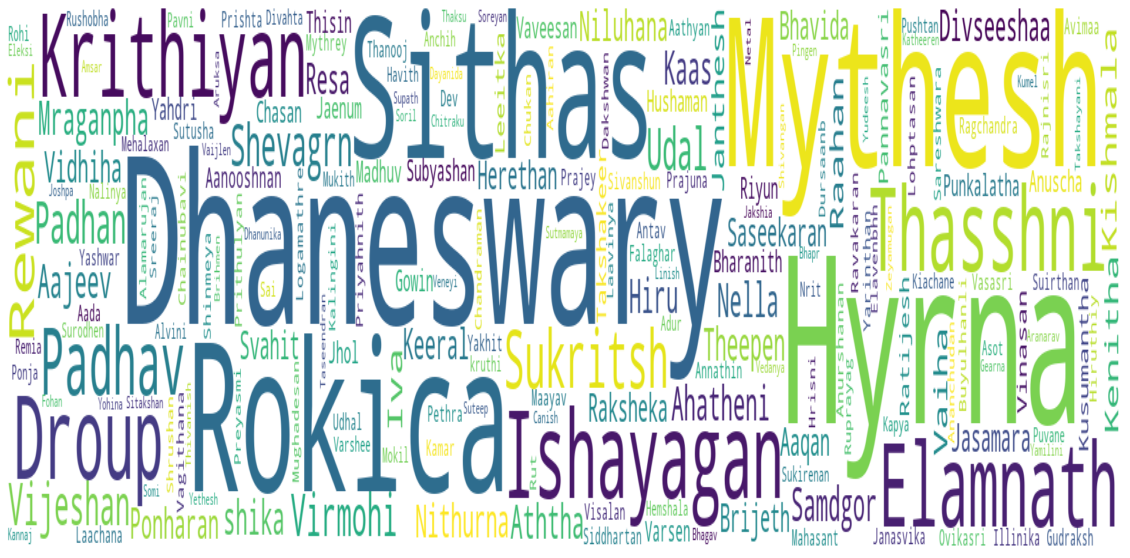

In [26]:
new_names = []

while len(new_names) is not 200:
    name = generateName(predictor)
    if name not in names:
        new_names.append(name.lstrip())

wordcloud = WordCloud(background_color="white",height=400,width=1900).generate(" ".join(new_names))

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(wordcloud, interpolation='bilinear',aspect='auto')
ax.axis("off")
plt.show()

## Key Takeaways
* Having this much amount of names to train the model will consume **more time** if one uses **CPU** but using **TPU** for the training the model will consume **less time**.
* One can train for more **longer name length** to see the results.
* We can add **more layers of RNNs** to see how the results differ.

<font color="red" size=5>Please!!! Upvote this kernel if you find it useful.</font>